<a href="https://colab.research.google.com/github/srushtinandu/ML-Project/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries
We install transformers library that will help us in our neual network framework. 

In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 8.5MB/s 
     |████████████████████████████████| 3.3MB 35.1MB/s 
     |████████████████████████████████| 901kB 33.9MB/s 


## Importing packages and defining constants
The packages we will use include matplotlib, pandas, PyTorch, which is our general-purpose deep learning library of choice

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import pandas as pd

## Loading the dataset
We load the dataset, consisting of 12.8k news statements and other fields, and put them in a dataframe. 

In [4]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/train.tsv'
train_data = pd.read_csv(url, sep = '\t')
train_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']
train_data.head()

,ID,Label,Statement,subject(s),speaker,speaker's job,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context (venue / location of the speech or statement)
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


We drop the unwanted columns from the dataset

In [5]:
train_data = train_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])

Next, we check for class imbalance, and the total counts of all classes

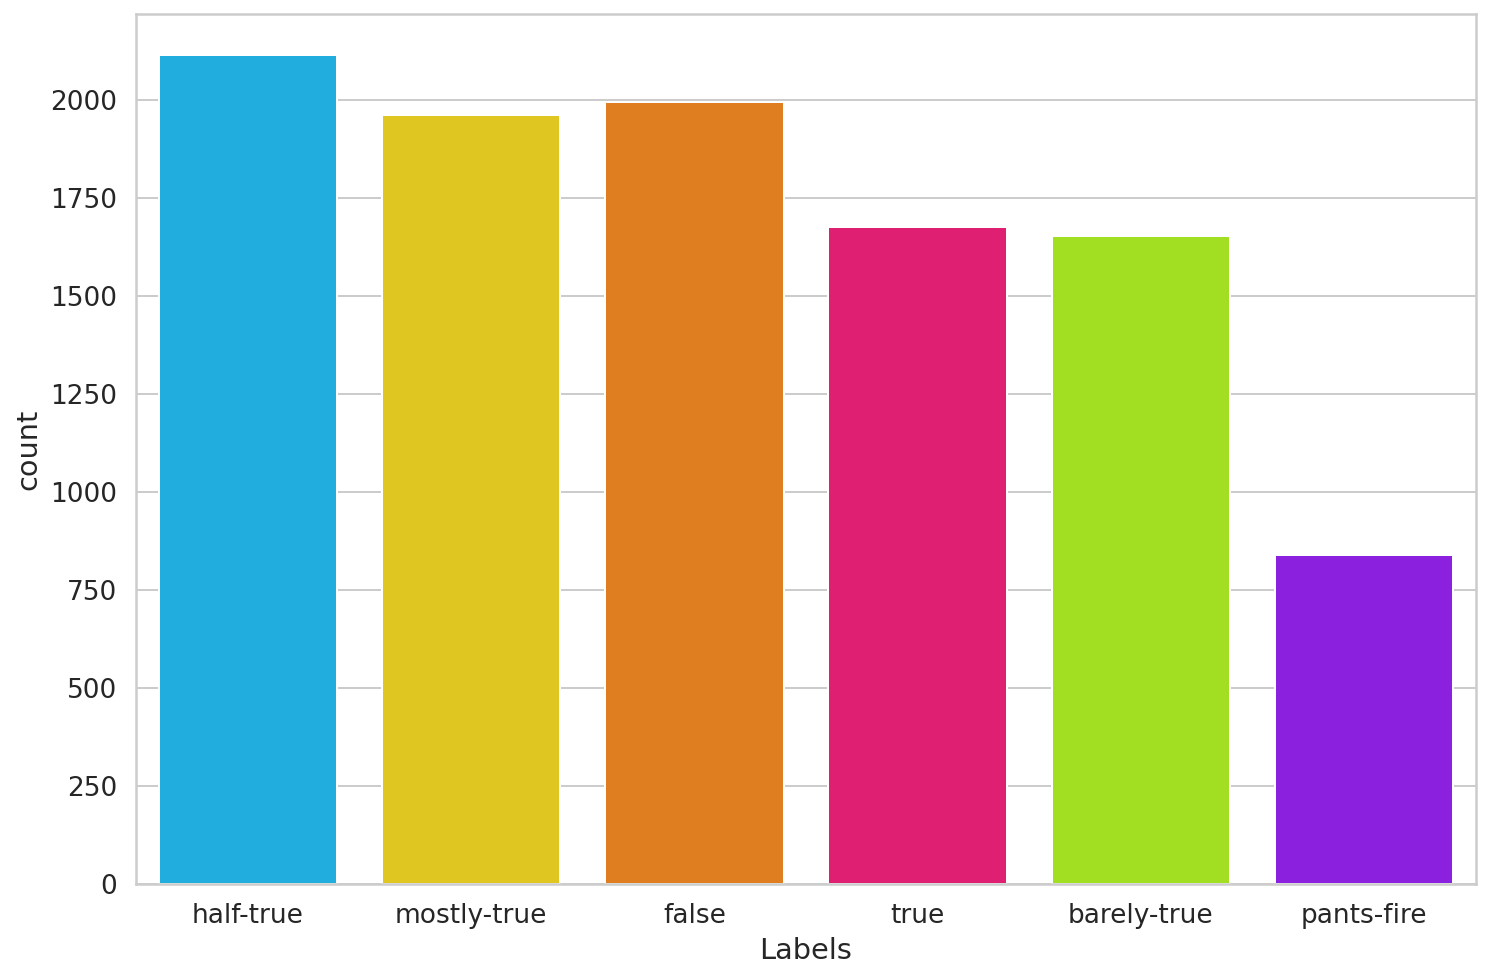

In [6]:
sns.countplot(x=train_data.Label)
plt.xlabel('Labels')
plt.show()

We want to convert the 6-class classification into a binary classification model, so we change the labels to true/false


In [7]:
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label

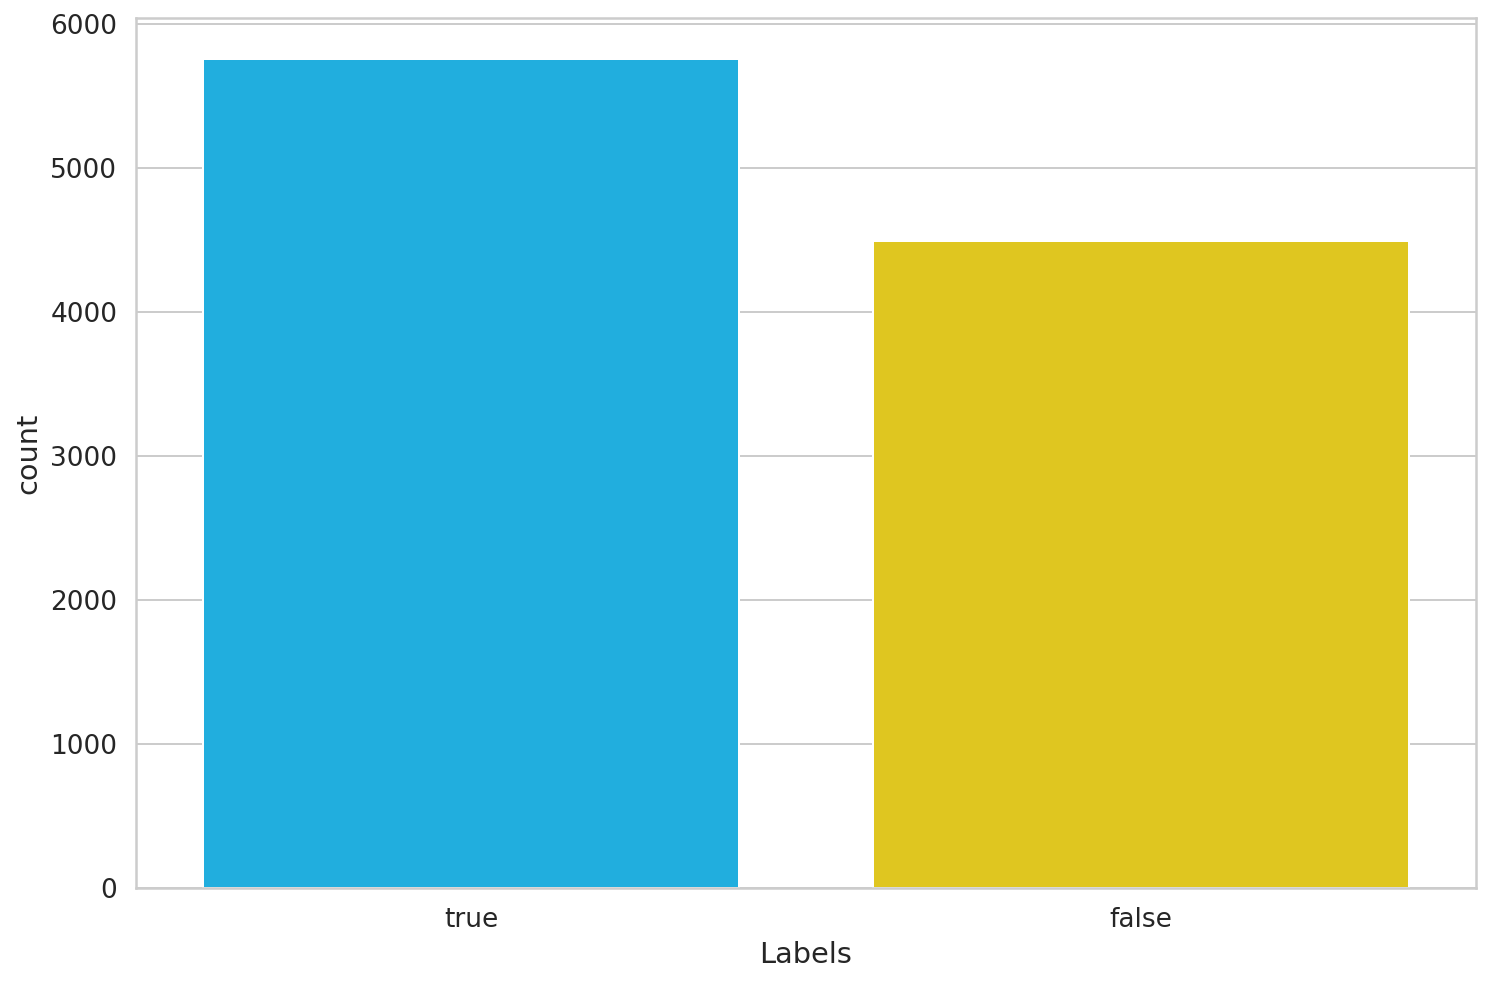

In [8]:
train_data['Label'] = train_data.Label.apply(to_label)
sns.countplot(x=train_data.Label)
plt.xlabel('Labels')
plt.show()

In [9]:
train_data.replace(['true', 'false'], [1,0], inplace=True)

In [10]:
class_names = ['true','false']

## Loading a pre-trained BertTokenizer


In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Choosing sequence length
We store the length of each statement in our dataset to determine the maximum length. 

In [12]:
token_lens = []
for txt in train_data.Statement:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))


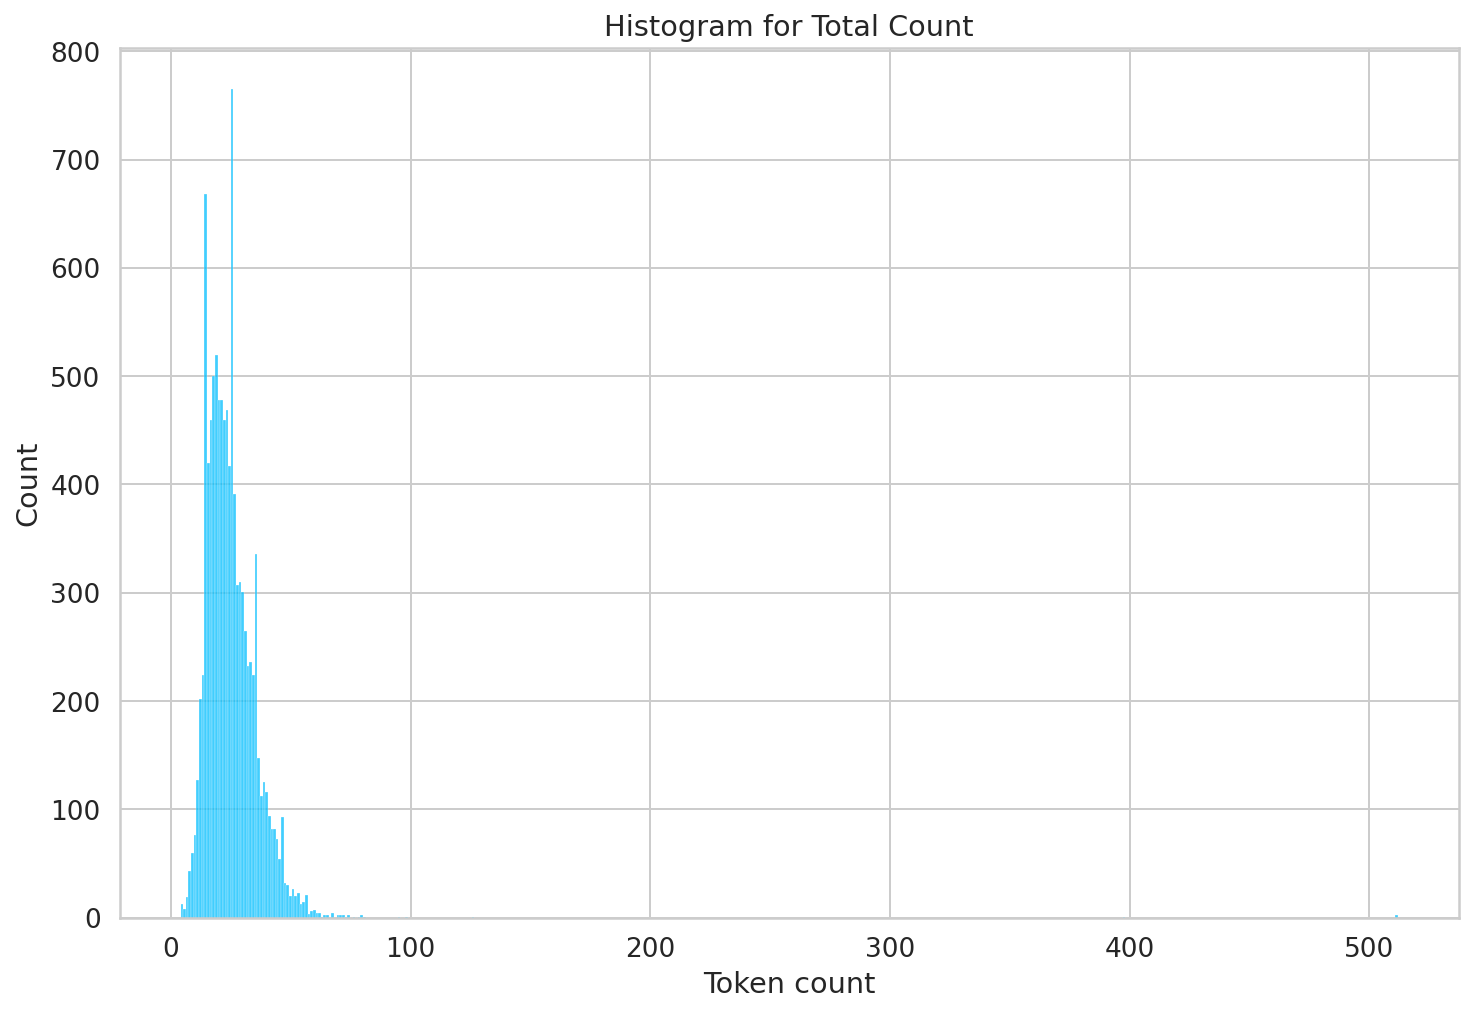

In [13]:
sns.histplot(token_lens)
plt.title("Histogram for Total Count")
plt.xlabel('Token count')
plt.show()

Defining some constants

In [33]:
MAX_LEN = 100 #defining the maximum length of the statements
BATCH_SIZE = 16
EPOCHS = 4

## Create a PyTorch dataset

In [34]:
class GPReviewDataset(Dataset):
  def __init__(self, statements, labels, tokenizer, max_len):
    self.statements = statements
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.statements)
  def __getitem__(self, item):
    statement = str(self.statements[item])
    label = self.labels[item]
    encoding = self.tokenizer.encode_plus(
      statement,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length = True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'statement_text': statement,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

We need to create data loaders, and hence we define a method for the same

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    statements=df.Statement.to_numpy(),
    labels=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  #print(df.Label.to_numpy())
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

# Creating Data Loader

In [36]:
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['statement_text', 'input_ids', 'attention_mask', 'labels'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Building a Fake News Classifier

In [40]:
class FakeNewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FakeNewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [41]:
model = FakeNewsClassifier(2)
model = model.to(device)

In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [43]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2668, 0.7332],
        [0.1898, 0.8102],
        [0.3020, 0.6980],
        [0.3765, 0.6235],
        [0.1601, 0.8399],
        [0.2275, 0.7725],
        [0.3918, 0.6082],
        [0.2026, 0.7974],
        [0.2022, 0.7978],
        [0.2477, 0.7523],
        [0.1745, 0.8255],
        [0.4264, 0.5736],
        [0.3002, 0.6998],
        [0.2237, 0.7763],
        [0.2417, 0.7583],
        [0.1619, 0.8381]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [44]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

## Training the Classifier


In [45]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for itr, d in enumerate(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)
    #print(d['statement_text'])
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if itr%20 == 0:
      completed = 16 * itr
      print(f"Train Epoch: {epoch+1} [{completed}/10239 ({int(completed * 100/10239)}%)]   Loss: {loss: .6f}")

  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/valid.tsv'
valid_data = pd.read_csv(url, sep = '\t')
valid_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']


In [48]:
valid_data = valid_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label
valid_data['Label'] = valid_data.Label.apply(to_label)
valid_data.replace(['true', 'false'], [1,0], inplace=True)



In [49]:
val_data_loader = create_data_loader(valid_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_data)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device, 
    len(valid_data)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  torch.save(model.state_dict(), f'model_epoch_{epoch+1}.bin')
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train Epoch: 1 [0/10239 (0%)]   Loss:  0.582708
Train Epoch: 1 [320/10239 (3%)]   Loss:  0.795725
Train Epoch: 1 [640/10239 (6%)]   Loss:  0.690642
Train Epoch: 1 [960/10239 (9%)]   Loss:  0.757464
Train Epoch: 1 [1280/10239 (12%)]   Loss:  0.583447
Train Epoch: 1 [1600/10239 (15%)]   Loss:  0.581281
Train Epoch: 1 [1920/10239 (18%)]   Loss:  0.691563
Train Epoch: 1 [2240/10239 (21%)]   Loss:  0.784270
Train Epoch: 1 [2560/10239 (25%)]   Loss:  0.666490
Train Epoch: 1 [2880/10239 (28%)]   Loss:  0.842799
Train Epoch: 1 [3200/10239 (31%)]   Loss:  0.615844
Train Epoch: 1 [3520/10239 (34%)]   Loss:  0.688952
Train Epoch: 1 [3840/10239 (37%)]   Loss:  0.807296
Train Epoch: 1 [4160/10239 (40%)]   Loss:  0.780638
Train Epoch: 1 [4480/10239 (43%)]   Loss:  0.867954
Train Epoch: 1 [4800/10239 (46%)]   Loss:  0.686414
Train Epoch: 1 [5120/10239 (50%)]   Loss:  0.707890
Train Epoch: 1 [5440/10239 (53%)]   Loss:  0.604621
Train Epoch: 1 [5760/10239 (56%)]   Loss:  0.661556
Train Epoch: 1 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6725149802219721 accuracy 0.5814497272018706

Epoch 2/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 2 [0/10239 (0%)]   Loss:  0.656585
Train Epoch: 2 [320/10239 (3%)]   Loss:  0.660887
Train Epoch: 2 [640/10239 (6%)]   Loss:  0.716567
Train Epoch: 2 [960/10239 (9%)]   Loss:  0.579541
Train Epoch: 2 [1280/10239 (12%)]   Loss:  0.526299
Train Epoch: 2 [1600/10239 (15%)]   Loss:  0.714433
Train Epoch: 2 [1920/10239 (18%)]   Loss:  0.931081
Train Epoch: 2 [2240/10239 (21%)]   Loss:  0.597603
Train Epoch: 2 [2560/10239 (25%)]   Loss:  0.683421
Train Epoch: 2 [2880/10239 (28%)]   Loss:  0.667244
Train Epoch: 2 [3200/10239 (31%)]   Loss:  0.707528
Train Epoch: 2 [3520/10239 (34%)]   Loss:  0.510759
Train Epoch: 2 [3840/10239 (37%)]   Loss:  0.791743
Train Epoch: 2 [4160/10239 (40%)]   Loss:  0.705855
Train Epoch: 2 [4480/10239 (43%)]   Loss:  0.658911
Train Epoch: 2 [4800/10239 (46%)]   Loss:  0.703964
Train Epoch: 2 [5120/10239 (50%)]   Loss:  0.704688
Train Epoch: 2 [5440/10239 (53%)]   Loss:  0.737205
Train Epoch: 2 [5760/10239 (56%)]   Loss:  0.537158
Train Epoch: 2 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6699671230198424 accuracy 0.6063912704598597

Epoch 3/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 3 [0/10239 (0%)]   Loss:  0.721510
Train Epoch: 3 [320/10239 (3%)]   Loss:  0.644867
Train Epoch: 3 [640/10239 (6%)]   Loss:  0.703035
Train Epoch: 3 [960/10239 (9%)]   Loss:  0.615976
Train Epoch: 3 [1280/10239 (12%)]   Loss:  0.594196
Train Epoch: 3 [1600/10239 (15%)]   Loss:  0.692577
Train Epoch: 3 [1920/10239 (18%)]   Loss:  0.794963
Train Epoch: 3 [2240/10239 (21%)]   Loss:  0.553586
Train Epoch: 3 [2560/10239 (25%)]   Loss:  0.635999
Train Epoch: 3 [2880/10239 (28%)]   Loss:  0.906179
Train Epoch: 3 [3200/10239 (31%)]   Loss:  0.687609
Train Epoch: 3 [3520/10239 (34%)]   Loss:  0.550993
Train Epoch: 3 [3840/10239 (37%)]   Loss:  0.807205
Train Epoch: 3 [4160/10239 (40%)]   Loss:  0.713320
Train Epoch: 3 [4480/10239 (43%)]   Loss:  0.740672
Train Epoch: 3 [4800/10239 (46%)]   Loss:  0.712341
Train Epoch: 3 [5120/10239 (50%)]   Loss:  0.597667
Train Epoch: 3 [5440/10239 (53%)]   Loss:  0.661664
Train Epoch: 3 [5760/10239 (56%)]   Loss:  0.551610
Train Epoch: 3 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6656930682099895 accuracy 0.612626656274357

Epoch 4/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Epoch: 4 [0/10239 (0%)]   Loss:  0.573703
Train Epoch: 4 [320/10239 (3%)]   Loss:  0.634446
Train Epoch: 4 [640/10239 (6%)]   Loss:  0.813177
Train Epoch: 4 [960/10239 (9%)]   Loss:  0.667012
Train Epoch: 4 [1280/10239 (12%)]   Loss:  0.740275
Train Epoch: 4 [1600/10239 (15%)]   Loss:  0.708775
Train Epoch: 4 [1920/10239 (18%)]   Loss:  0.721716
Train Epoch: 4 [2240/10239 (21%)]   Loss:  0.501114
Train Epoch: 4 [2560/10239 (25%)]   Loss:  0.526879
Train Epoch: 4 [2880/10239 (28%)]   Loss:  0.963124
Train Epoch: 4 [3200/10239 (31%)]   Loss:  0.615694
Train Epoch: 4 [3520/10239 (34%)]   Loss:  0.559409
Train Epoch: 4 [3840/10239 (37%)]   Loss:  0.725145
Train Epoch: 4 [4160/10239 (40%)]   Loss:  0.748471
Train Epoch: 4 [4480/10239 (43%)]   Loss:  0.662388
Train Epoch: 4 [4800/10239 (46%)]   Loss:  0.794587
Train Epoch: 4 [5120/10239 (50%)]   Loss:  0.523788
Train Epoch: 4 [5440/10239 (53%)]   Loss:  0.681169
Train Epoch: 4 [5760/10239 (56%)]   Loss:  0.471690
Train Epoch: 4 [6080/1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6610177472049807 accuracy 0.6180826188620421



## Visualizing Results

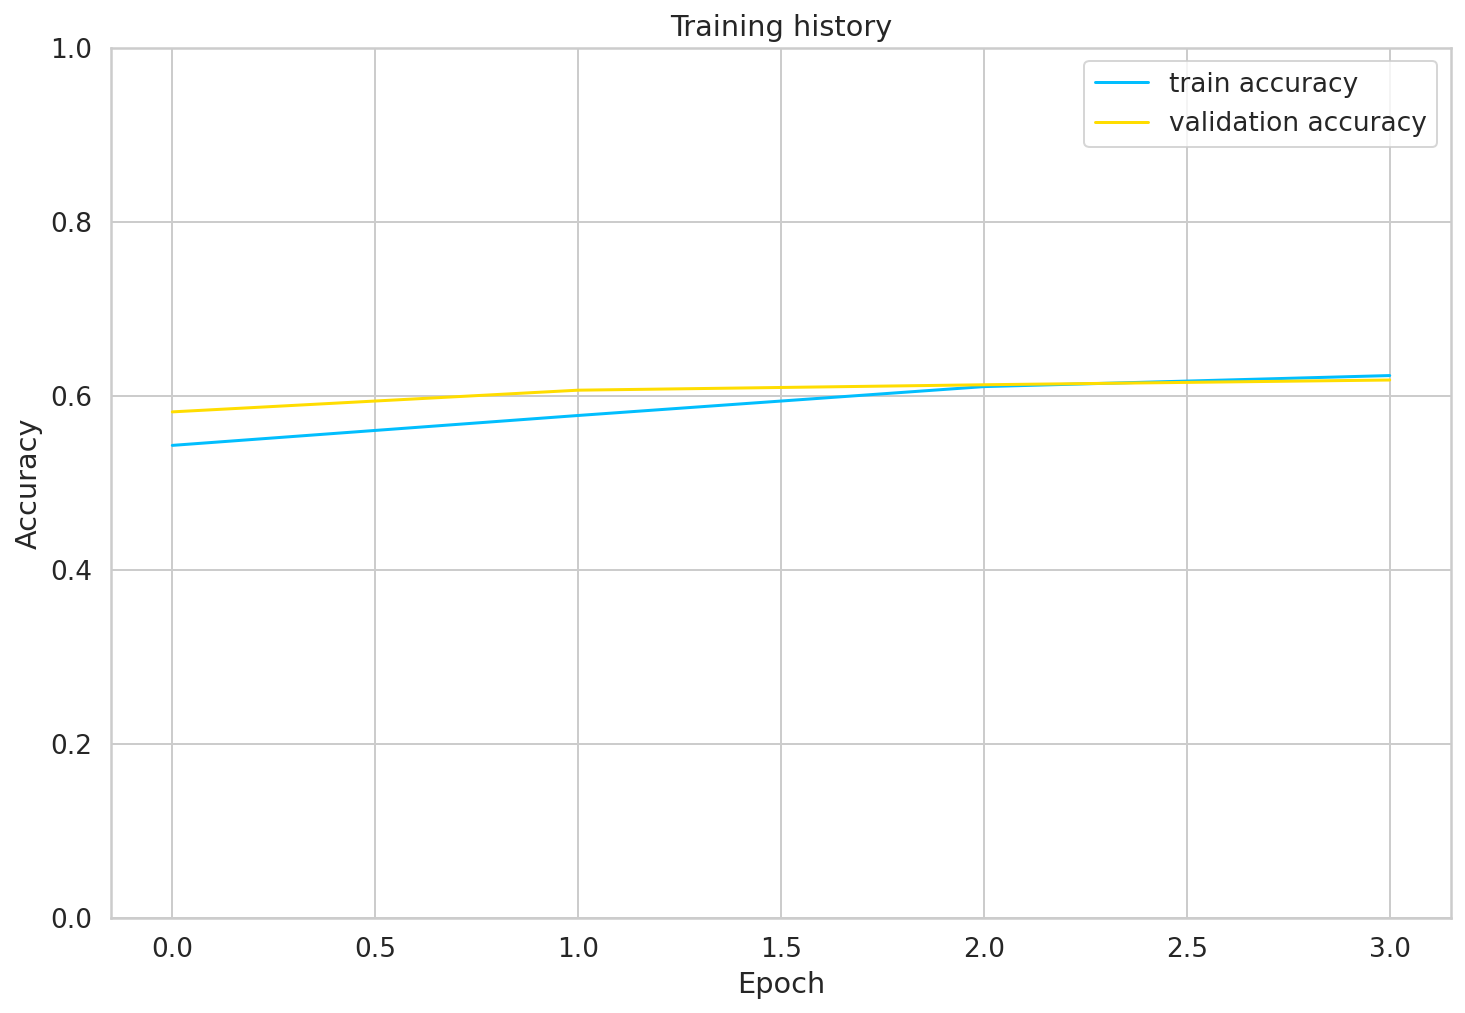

In [51]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);                                                                                                                                                                                                           

In [52]:
url = 'https://raw.githubusercontent.com/srushtinandu/NLP-Project/main/data/test.tsv'
test_data = pd.read_csv(url, sep = '\t')
test_data.columns=['ID', 'Label', 'Statement', 'subject(s)', 'speaker', 'speaker\'s job', 'state info', 'party affiliation', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts', 'context (venue / location of the speech or statement)']

In [53]:
test_data = test_data.drop(columns=['ID', 'barely true counts', 'false counts', 'half true counts', 'mostly true counts', 'pants on fire counts'])
def to_label(label):
  if label == 'mostly-true' or label == 'half-true':
    return 'true'
  elif label == 'pants-fire' or label == 'barely-true':
    return 'false'
  else:
    return label
test_data['Label'] = test_data.Label.apply(to_label)
test_data.replace(['true', 'false'], [1,0], inplace=True)

In [54]:
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.6042654028436019

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  statement_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["statement_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      statement_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return statement_texts, predictions, prediction_probs, real_values

In [57]:
y_statement_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [58]:
true_negatives = []
true_positives = []
false_negatives = []
false_positives = []
for i in range(len(y_statement_texts)):
  if y_pred[i] == 0 and y_test[i] == 0:
    if len(true_negatives) < 30:
      true_negatives.append(y_statement_texts[i])
  elif y_pred[i] == 1 and y_test[i] == 1:
    if len(true_positives) < 30:
      true_positives.append(y_statement_texts[i])
  elif y_pred[i] == 0 and y_test[i] == 1:
    if len(false_negatives) < 30:
      false_negatives.append(y_statement_texts[i])
  elif y_pred[i] == 1 and y_test[i] == 0:
    if len(false_positives) < 30:
      false_positives.append(y_statement_texts[i])
print('True Negative Statements')
print(true_negatives)
print()
print('True Positive Statements')
print(true_positives)
print()
print('False Negative Statements')
print(false_negatives)
print()
print('False Positive Statements')
print(false_positives)
print()


  

True Negative Statements
['Says John McCain has done nothing to help the vets.', 'When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.', 'Says Vice President Joe Biden "admits that the American people are being scammed" with the economic stimulus package.', 'PolitiFact Texas says Congressman Edwards attacks on Bill Flores are false.', 'Denali is the Kenyan word for black power.', 'Unfortunately we have documented instances where people defecated in the (Statehouse) building.', 'Says Charlie Crist is embroiled in a fraud case for steering taxpayer money to a de facto Ponzi scheme.', 'I was gone when there was a red line against Syria.', 'Under Rosemary Lehmberg, the Travis County D.A.s office convened the grand jury that indicted Rick Perry.', 'Pre-existing conditions are covered under my (health care) plan.', 'Says he won the second debate with Hillary Clinton in a landslide in every poll.', 'Says bag litter inc

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        true       0.54      0.58      0.56       553
       false       0.66      0.63      0.64       713

    accuracy                           0.60      1266
   macro avg       0.60      0.60      0.60      1266
weighted avg       0.61      0.60      0.61      1266



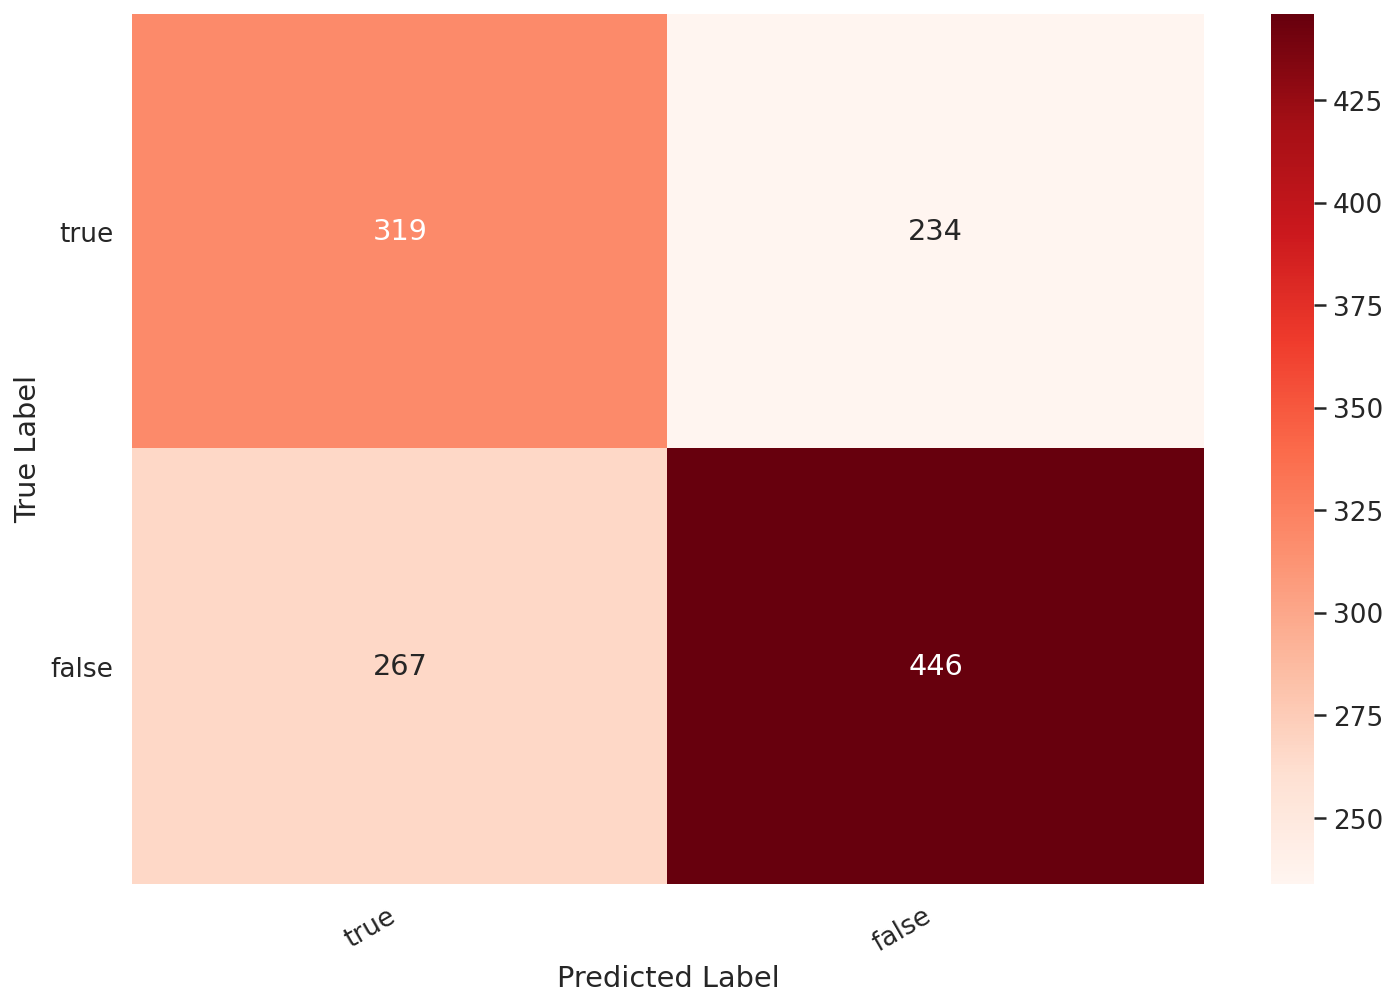

In [60]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)